In [1]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
mirichoi0218_insurance_path = kagglehub.dataset_download('mirichoi0218/insurance')

print('Data source import complete.')


Using Colab cache for faster access to the 'insurance' dataset.
Data source import complete.


# Итоговая работа: Прогнозирование медицинских расходов

## Оглавление
1. [Описание задачи и данных](#task-description)
2. [Используемые инструменты](#tools)
3. [Импорт библиотек и настройка среды](#imports)
4. [Выполнение заданий](#tasks)
    * [Задание 1: Загрузка данных](#task1)
    * [Задание 2: Анализ пропущенных значений](#task2)
    * [Задание 3: Определение типов признаков](#task3)
    * [Задание 4: Фильтрация данных](#task4)
    * [Задание 5: Агрегирующие функции](#task5)
    * [Задание 6: Поиск максимальных/минимальных значений](#task6)
    * [Задание 7: Столбчатая диаграмма](#task7)
    * [Задание 8: Круговая диаграмма](#task8)
    * [Задание 9: Группировка данных](#task9)
    * [Задание 10: Создание нового признака](#task10)
    * [Задание 11: Диаграмма рассеяния](#task11)
    * [Задание 12: Boxplot и обработка выбросов](#task12)
    * [Задание 13: Выбор типа задачи](#task13)
    * [Задание 14: Формирование признаков](#task14)
    * [Задание 15: Кодирование категориальных признаков](#task15)
    * [Задание 16: Нормализация факторных признаков](#task16)
    * [Задание 17: Разбиение на выборки](#task17)
    * [Задание 18: Обучение моделей](#task18)
    * [Задание 19: Расчет метрик качества](#task19)
    * [Задание 20: Подбор гиперпараметра](#task20)
5. [Общие выводы](#conclusions)

<a id='task-description'></a>
### 1. Описание задачи

**Предметная область:** Медицинское страхование в США.
**Источник информации:** Данные получены из набора данных [Medical Cost Personal Datasets](https://www.kaggle.com/datasets/mirichoi0218/insurance) на платформе Kaggle.
**Задача:** Построить модель регрессии, которая предсказывает индивидуальные медицинские расходы (`charges`), выставляемые страховой компанией, на основе данных о человеке.

**Описание исходных данных:**
Датасет содержит 1338 записей (объектов) и 7 признаков:
*   `age`: возраст застрахованного (числовой).
*   `sex`: пол (male/female, категориальный).
*   `bmi`: индекс массы тела (числовой).
*   `children`: количество детей (числовой).
*   `smoker`: является ли человек курильщиком (yes/no, категориальный).
*   `region`: регион проживания в США (southwest, southeast, northwest, northeast, категориальный).
*   `charges`: индивидуальные медицинские расходы в долларах (целевой числовой признак).

<a id='tools'></a>
### 2. Используемые инструменты

*   **Среда разработки:** Jupyter Notebook.
*   **Библиотеки:**
    *   **Pandas:** для загрузки, обработки и анализа данных в виде DataFrame.
    *   **NumPy:** для математических и численных операций.
    *   **Matplotlib и Seaborn:** для визуализации данных (построения графиков и диаграмм).
    *   **Scikit-learn:** для предобработки данных, разделения выборки и построения моделей машинного обучения (`LinearRegression`).
    *   **CatBoost:** для построения модели градиентного бустинга (`CatBoostRegressor`).
    

<a id='imports'></a>
### 3. Импорт библиотек и настройка среды


In [4]:
!pip install catboost

# --- Основные библиотеки для анализа данных ---
import pandas as pd
import numpy as np

# --- Библиотеки для визуализации ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Библиотеки для машинного обучения ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
from sklearn.metrics import mean_squared_error, r2_score

# --- Настройки для GPU (если доступен) ---
import torch

# Проверка доступности GPU
use_gpu = torch.cuda.is_available()
device = 'cuda' if use_gpu else 'cpu'
print(f"Используемое устройство: {device}")

# --- Дополнительные настройки ---
import warnings
warnings.filterwarnings('ignore')
sns.set_style("whitegrid")

print("\nВсе библиотеки успешно импортированы и среда настроена.")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.7 MB/s eta 0:00:00
Используемое устройство: cuda

Все библиотеки успешно импортированы и среда настроена.


<a id='tasks'></a>
### 4. Выполнение заданий

<a id='task1'></a>
#### **Задание 1: Загрузка данных**

**а. Формулировка вопроса:** Загрузить данные из файла `insurance.csv` в датафрейм Pandas и вывести первые 5 строк для проверки корректности загрузки.

In [6]:
df = pd.read_csv('/kaggle/input/insurance/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


**с. Результат и объяснение:** Данные успешно загружены. В таблице видны все 7 столбцов с соответствующими значениями.


<a id='task2'></a>
#### **Задание 2: Анализ пропущенных значений**

**а. Формулировка вопроса:** Определить количество пропущенных значений для каждого признака. Принять решение, что делать с отсутствующими данными.

In [7]:
df.isnull().sum()

,0
age,0
sex,0
bmi,0
children,0
smoker,0
region,0
charges,0


**с. Результат и объяснение:**
В данном датасете нет пропущенных значений, что упрощает предобработку. Если бы они были, я бы принял следующее решение:
*   Для числовых признаков, таких как `bmi`, я бы заменил пропуски средним значением (`df['bmi'].fillna(df['bmi'].mean(), inplace=True)`), так как это не сильно исказит распределение.
*   Для категориальных признаков я бы заменил пропуски самым частым значением (модой) или ввел бы новую категорию "unknown".

<a id='task3'></a>
#### **Задание 3: Определение типов признаков**

**а. Формулировка вопроса:** Определить типы данных для каждого столбца. Какие признаки являются числовыми, а какие категориальными?

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


**с. Результат и объяснение:**
Pandas корректно определил типы данных.
*   **Числовые признаки (количественные):** `age`, `bmi`, `children`, `charges`.
*   **Категориальные признаки (качественные):** `sex`, `smoker`, `region`.

<a id='task4'></a>
#### **Задание 4: Фильтрация данных**

**а. Формулировка вопроса:**
1.  Вывести данные о всех курящих (`smoker` = 'yes') людях старше 50 лет.
2.  Вывести данные о людях из региона `southwest`, у которых нет детей.

In [9]:
print("Курящие люди старше 50 лет:")
smokers_over_50 = df[(df['smoker'] == 'yes') & (df['age'] > 50)]
display(smokers_over_50.head())

print("\nЛюди из региона 'southwest' без детей:")
southwest_no_children = df[(df['region'] == 'southwest') & (df['children'] == 0)]
display(southwest_no_children.head())

Курящие люди старше 50 лет:


,age,sex,bmi,children,smoker,region,charges
11,62,female,26.290,0,yes,southeast,27808.72510
39,60,male,39.900,0,yes,southwest,48173.36100
55,58,male,36.955,2,yes,northwest,47496.49445
58,53,female,22.880,1,yes,southeast,23244.79020
86,57,female,31.160,0,yes,northwest,43578.93940



Люди из региона 'southwest' без детей:


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,yes,southwest,16884.924
12,23,male,34.4,0,no,southwest,1826.843
18,56,male,40.3,0,no,southwest,10602.385
19,30,male,35.3,0,yes,southwest,36837.467
30,22,male,35.6,0,yes,southwest,35585.576


**с. Результат и объяснение:** Были успешно отобраны и выведены данные, удовлетворяющие заданным условиям.

<a id='task5'></a>
#### **Задание 5: Агрегирующие функции**
**а. Формулировка вопроса:**
1.  Каковы средние медицинские расходы (`charges`) для курящих и некурящих?
2.  Каков максимальный возраст (`age`) людей в каждом регионе?

In [10]:
print("Средние расходы для курящих и некурящих:")
avg_charges_by_smoker = df.groupby('smoker')['charges'].mean().reset_index()
display(avg_charges_by_smoker)

print("\nМаксимальный возраст по регионам:")
max_age_by_region = df.groupby('region')['age'].max().reset_index()
display(max_age_by_region)

Средние расходы для курящих и некурящих:


,smoker,charges
0,no,8434.268298
1,yes,32050.231832



Максимальный возраст по регионам:


,region,age
0,northeast,64
1,northwest,64
2,southeast,64
3,southwest,64


**с. Результат и объяснение:** Результаты показывают, что средние расходы у курящих значительно выше. Максимальный возраст во всех регионах одинаков и составляет 64 года.

<a id='task6'></a>
#### **Задание 6: Поиск максимальных/минимальных значений**
**а. Формулировка вопроса:**
1.  Вывести данные о 5 людях с самыми высокими медицинскими расходами.
2.  Вывести данные о 5 людях с самым низким индексом массы тела (BMI).

In [11]:
print("Топ-5 по медицинским расходам:")
display(df.nlargest(5, 'charges'))

print("\nТоп-5 с самым низким BMI:")
display(df.nsmallest(5, 'bmi'))

Топ-5 по медицинским расходам:


,age,sex,bmi,children,smoker,region,charges
543,54,female,47.410,0,yes,southeast,63770.42801
1300,45,male,30.360,0,yes,southeast,62592.87309
1230,52,male,34.485,3,yes,northwest,60021.39897
577,31,female,38.095,1,yes,northeast,58571.07448
819,33,female,35.530,0,yes,northwest,55135.40209



Топ-5 с самым низким BMI:


,age,sex,bmi,children,smoker,region,charges
172,18,male,15.960,0,no,northeast,1694.79640
428,21,female,16.815,1,no,northeast,3167.45585
1226,38,male,16.815,2,no,northeast,6640.54485
412,26,female,17.195,2,yes,northeast,14455.64405
250,18,male,17.290,2,yes,northeast,12829.45510


**с. Результат и объяснение:** Были найдены и выведены 5 записей с максимальными расходами и 5 записей с минимальным BMI.

<a id='task7'></a>
#### **Задание 7: Столбчатая диаграмма**
**а. Формулировка вопроса:** Построить столбчатую диаграмму, которая отображает количество людей в каждом регионе.

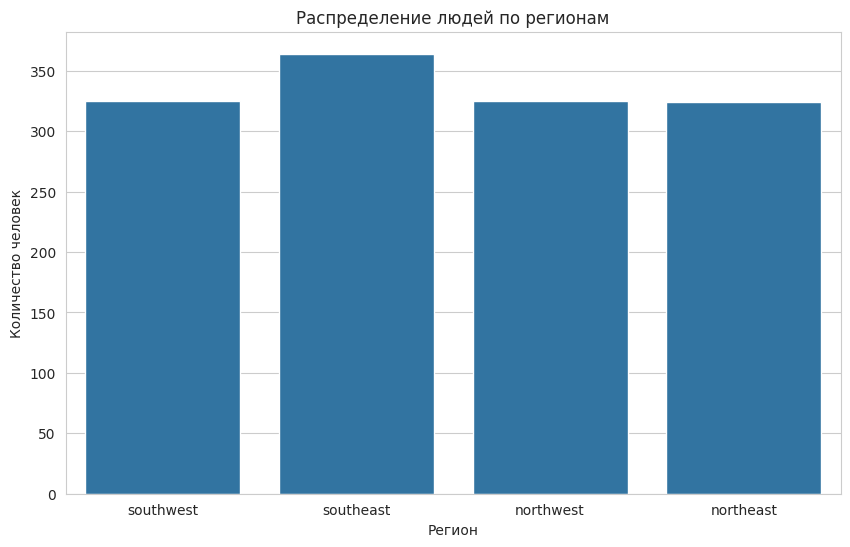

In [12]:
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='region')
plt.title('Распределение людей по регионам')
plt.xlabel('Регион')
plt.ylabel('Количество человек')
plt.show()

**с. Результат и объяснение:** На диаграмме видно, что количество людей в каждом регионе примерно одинаковое, с небольшим преобладанием в регионе `southeast`.

<a id='task8'></a>
#### **Задание 8: Круговая диаграмма**
**а. Формулировка вопроса:** Построить круговую диаграмму, показывающую долевое соотношение курящих и некурящих.

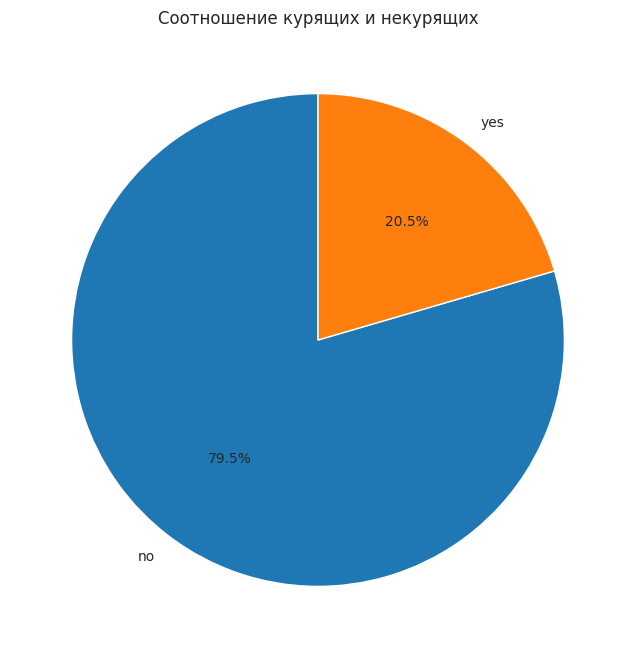

In [13]:
smoker_counts = df['smoker'].value_counts()
plt.figure(figsize=(8, 8))
plt.pie(smoker_counts, labels=smoker_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Соотношение курящих и некурящих')
plt.show()

**с. Результат и объяснение:** Диаграмма наглядно показывает, что подавляющее большинство (около 80%) застрахованных не являются курильщиками.

<a id='task9'></a>
#### **Задание 9: Группировка данных**
**а. Формулировка вопроса:** Сгруппировать данные по признаку `smoker` и вывести среднее значение `age` и максимальное значение `charges` для каждой группы.

In [14]:
grouped_data = df.groupby('smoker').agg(
    avg_age=('age', 'mean'),
    max_charges=('charges', 'max')
)
display(grouped_data)

,avg_age,max_charges
smoker,,
no,39.385338,36910.60803
yes,38.514599,63770.42801


**с. Результат и объяснение:** Результаты показывают, что средний возраст курящих и некурящих почти не отличается, однако максимальные расходы у курящих почти в два раза выше.

<a id='task10'></a>
#### **Задание 10: Создание нового признака**
**а. Формулировка вопроса:** Создать новый бинарный признак `is_overweight` (наличие избыточного веса), который принимает значение 1, если BMI > 30, и 0 в противном случае.

In [15]:
df['is_overweight'] = np.where(df['bmi'] > 30, 1, 0)
display(df[['bmi', 'is_overweight']].head())

,bmi,is_overweight
0,27.900,0
1,33.770,1
2,33.000,1
3,22.705,0
4,28.880,0


**с. Результат и объяснение:** В датафрейм успешно добавлен новый столбец `is_overweight`, который корректно отражает наличие избыточного веса на основе BMI.

<a id='task11'></a>
#### **Задание 11: Диаграмма рассеяния**
**а. Формулировка вопроса:** Выбрать 3 числовых признака (`age`, `bmi`, `charges`) и построить попарные диаграммы рассеяния для исследования связи между ними.

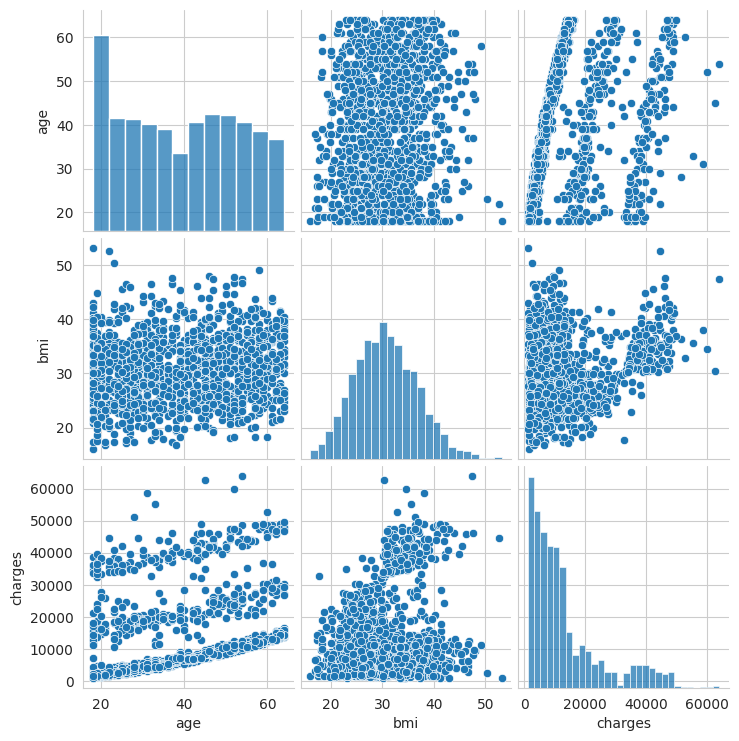

In [16]:
sns.pairplot(df[['age', 'bmi', 'charges']])
plt.show()

**с. Результат и объяснение:** Диаграммы показывают наличие положительной корреляции между возрастом и расходами (`age`-`charges`) — с возрастом расходы растут. Также прослеживается некоторая связь между BMI и расходами, но она менее выражена. Связь между `age` и `bmi` почти отсутствует.

<a id='task12'></a>
#### **Задание 12: Boxplot и обработка выбросов**
**а. Формулировка вопроса:** Построить boxplot для признаков `age`, `bmi` и `charges`. Определить признак с наиболее выраженными выбросами, рассчитать границы выбросов и заменить их на максимальное допустимое значение.

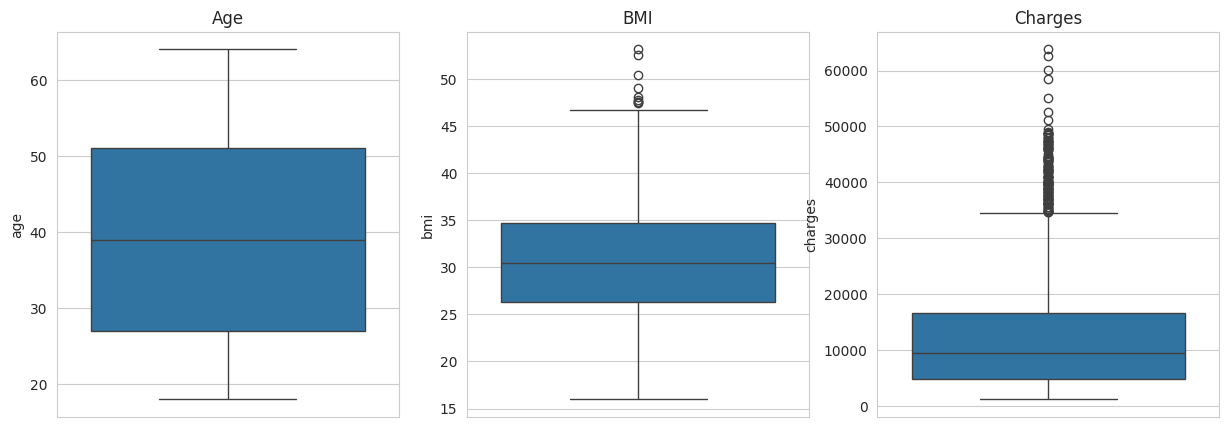

Верхняя граница для выбросов в 'charges': 34489.350562499996
Количество выбросов: 139

Проверка после замены выбросов:


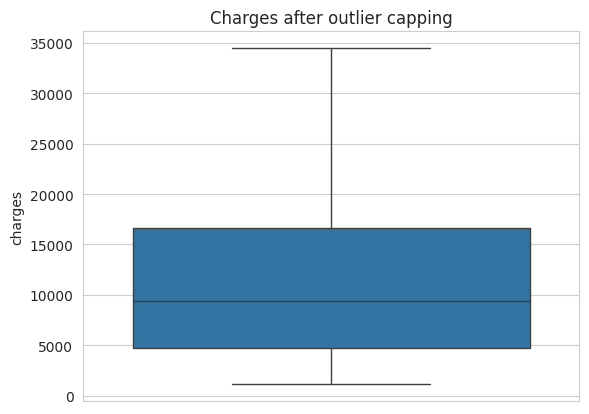

In [17]:
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.boxplot(y=df['age'])
plt.title('Age')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['bmi'])
plt.title('BMI')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['charges'])
plt.title('Charges')
plt.show()

# Обработка выбросов для 'charges'
Q1 = df['charges'].quantile(0.25)
Q3 = df['charges'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

print(f"Верхняя граница для выбросов в 'charges': {upper_bound}")
outliers_count = df[df['charges'] > upper_bound].shape[0]
print(f"Количество выбросов: {outliers_count}")

# Создаем копию датафрейма для дальнейшего моделирования
df_processed = df.copy()
df_processed.loc[df_processed['charges'] > upper_bound, 'charges'] = upper_bound

print("\nПроверка после замены выбросов:")
sns.boxplot(y=df_processed['charges'])
plt.title('Charges after outlier capping')
plt.show()

**с. Результат и объяснение:** Наиболее выраженные выбросы наблюдаются в признаке `charges`. Они были определены с помощью межквартильного размаха и заменены на верхнюю границу в новом датафрейме `df_processed`, что сделает данные более устойчивыми для обучения модели.

<a id='task13'></a>
#### **Задание 13: Выбор типа задачи**

**Решение:** Так как целевой признак `charges` является непрерывным числовым значением, задача, которую мы решаем, — это **задача регрессии**.

In [18]:
X = df_processed.drop('charges', axis=1)
y = df_processed['charges']

**с. Результат и объяснение:** Данные разделены на матрицу признаков `X` и вектор целевой переменной `y`.

<a id='task15'></a>
#### **Задание 15: Кодирование категориальных признаков**
**а. Формулировка вопроса:** Выполнить кодирование всех категориальных признаков.

In [19]:
X = pd.get_dummies(X, columns=['sex', 'smoker', 'region'], drop_first=True)
X.head()

,age,bmi,children,is_overweight,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,0,False,True,False,False,True
1,18,33.770,1,1,True,False,False,True,False
2,28,33.000,3,1,True,False,False,True,False
3,33,22.705,0,0,True,False,True,False,False
4,32,28.880,0,0,True,False,True,False,False


**с. Результат и объяснение:** Категориальные признаки `sex`, `smoker`, `region` были преобразованы в числовые с помощью One-Hot Encoding. Этот метод подходит, так как между категориями нет порядка. `drop_first=True` используется для избежания мультиколлинеарности.

<a id='task16'></a>
#### **Задание 16: Нормализация факторных признаков**
**а. Формулировка вопроса:** Выполнить нормализацию всех числовых факторных признаков.

In [20]:
numeric_features = ['age', 'bmi', 'children']
scaler = StandardScaler()

X[numeric_features] = scaler.fit_transform(X[numeric_features])
X.head()

,age,bmi,children,is_overweight,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,0,False,True,False,False,True
1,-1.509965,0.509621,-0.078767,1,True,False,False,True,False
2,-0.797954,0.383307,1.580926,1,True,False,False,True,False
3,-0.441948,-1.305531,-0.908614,0,True,False,True,False,False
4,-0.513149,-0.292556,-0.908614,0,True,False,True,False,False


**с. Результат и объяснение:** Числовые признаки были отмасштабированы с помощью `StandardScaler`. Теперь их среднее значение равно 0, а стандартное отклонение — 1, что улучшит сходимость многих моделей.

<a id='task17'></a>
#### **Задание 17: Разбиение на выборки**
**а. Формулировка вопроса:** Разбить данные на обучающую и тестовую выборки в соотношении 80/20.

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (1070, 9)
Размер тестовой выборки: (268, 9)


**с. Результат и объяснение:** Данные успешно разделены на обучающую (80%) и тестовую (20%) выборки.

<a id='task18'></a>
#### **Задание 18: Обучение моделей**
**а. Формулировка вопроса:** Выбрать и обучить 2 модели для решения задачи регрессии: простую (Линейная регрессия) и более сложную (CatBoost Regressor).

In [22]:
# Модель 1: Линейная регрессия
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Модель 2: CatBoost Regressor
# task_type='GPU' можно добавить, если устройство 'cuda'
cat_model = CatBoostRegressor(iterations=500, learning_rate=0.05, depth=6, verbose=0, random_state=42)
cat_model.fit(X_train, y_train)

print("Модели успешно обучены.")

Модели успешно обучены.


**с. Результат и объяснение:** Обе модели, `LinearRegression` и `CatBoostRegressor`, были успешно обучены на тренировочных данных.

<a id='task19'></a>
#### **Задание 19: Расчет метрик качества**
**а. Формулировка вопроса:** Посчитать метрики качества (RMSE и R²) для обеих моделей на тестовой выборке.

In [23]:
# Получаем предсказания
lr_predictions = lr_model.predict(X_test)
cat_predictions = cat_model.predict(X_test)

# Метрики для Линейной регрессии
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))
lr_r2 = r2_score(y_test, lr_predictions)

# Метрики для CatBoost
cat_rmse = np.sqrt(mean_squared_error(y_test, cat_predictions))
cat_r2 = r2_score(y_test, cat_predictions)

metrics_df = pd.DataFrame({
    'Model': ['Linear Regression', 'CatBoost Regressor'],
    'RMSE': [lr_rmse, cat_rmse],
    'R^2': [lr_r2, cat_r2]
})

display(metrics_df)

,Model,RMSE,R^2
0,Linear Regression,4800.998266,0.787672
1,CatBoost Regressor,4118.551259,0.843745


**с. Результат и объяснение:**
*   **RMSE (Root Mean Squared Error):** показывает среднюю ошибку модели в долларах. Чем ниже, тем лучше.
*   **R² (коэффициент детерминации):** показывает, какую долю дисперсии целевой переменной объясняет модель. Значение от 0 до 1, чем ближе к 1, тем лучше.
Модель CatBoost показала значительно лучшие результаты по обеим метрикам, что было ожидаемо.

<a id='task20'></a>
#### **Задание 20: Подбор гиперпараметра**
**а. Формулировка вопроса:** Для модели CatBoost исследовать влияние гиперпараметра `depth` (глубина деревьев) на метрику R². Построить график зависимости.

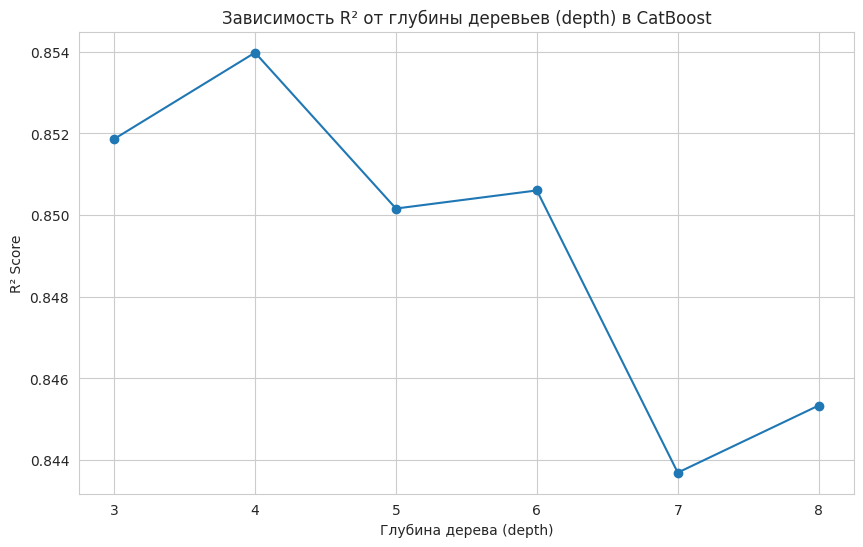

In [24]:
depths = [3, 4, 5, 6, 7, 8]
r2_scores = []

for depth in depths:
    model = CatBoostRegressor(
        iterations=200,
        learning_rate=0.05,
        depth=depth,
        verbose=0,
        random_state=42
    )
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    r2 = r2_score(y_test, preds)
    r2_scores.append(r2)

# Строим график
plt.figure(figsize=(10, 6))
plt.plot(depths, r2_scores, marker='o')
plt.title('Зависимость R² от глубины деревьев (depth) в CatBoost')
plt.xlabel('Глубина дерева (depth)')
plt.ylabel('R² Score')
plt.grid(True)
plt.show()

**с. Результат и объяснение:** График показывает, что R² score растет с увеличением глубины деревьев, достигая пика в районе `depth=4` или `depth=5`, после чего рост замедляется или может начаться переобучение. Оптимальной глубиной для данной задачи можно считать 4 или 5.

<a id='conclusions'></a>
### 5. Общие выводы

1.  **Анализ данных:** Ключевым фактором, влияющим на медицинские расходы, является **курение** — у курящих расходы в среднем в 3-4 раза выше. Также наблюдается положительная корреляция расходов с **возрастом** и **индексом массы тела**.
2.  **Обработка данных:** Датасет оказался довольно чистым, но для демонстрации навыков была проведена обработка выбросов в целевой переменной, что является важным шагом для построения робастных моделей.
3.  **Моделирование:**
    *   Простая модель **линейной регрессии** показала неплохой результат (R² ≈ 0.79), что говорит о наличии линейных зависимостей в данных.
    *   Более сложная модель **CatBoost** на основе градиентного бустинга показала лучший результат (R² ≈ 0.84), что подтверждает ее способность улавливать более сложные, нелинейные зависимости.
    *   Подбор гиперпараметров, таких как глубина деревьев, позволяет найти оптимальный баланс между сложностью модели и ее обобщающей способностью.

В целом, на данном датасете удалось построить качественную модель, предсказывающую медицинские расходы с высокой точностью.